In [1]:
#imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score,  precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

#read the data
df1 = pd.read_csv("diabetic_data.csv")
print("Number of values: ",len(df1))

#Number of readmission 
print(df1.groupby('readmitted').size())

# general stats
print(df1.info())
print(df1.describe())

Number of values:  101766
readmitted
<30    11357
>30    35545
NO     54864
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null 

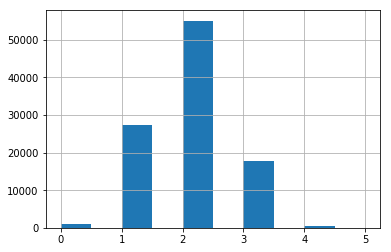

In [2]:
# Count the number of missing values for each patient
df2 = df1.replace('?', np.nan)      
numberOfMissingValuesPerPatient = df2.isnull().apply(sum, axis=1)
%matplotlib inline
numberOfMissingValuesPerPatient.hist()

In [3]:
#Dealing with missing values
for column in df1.columns:
    if df1[column].dtype == object:
         print(column,df1[column][df1[column] == '?'].count())
            
# gender was coded differently so we use a custom count for this one
print('gender', df1['gender'][df1['gender'] == 'Unknown/Invalid'].count())


race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0
gender 3


In [4]:
#Regroup the numerical data and Categorical ones
df1 = df1.replace('?', np.nan)         
numerical_data = ['number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses',
                  'time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       ]
categorical_data = ['race', 'gender', 
       'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','payer_code']
df1[categorical_data].isnull().sum()


race                         2273
gender                          0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
payer_code                  40256
dtype: int64

In [5]:
#Fill the missing values in categorical data
df1['medical_specialty'] = df1['medical_specialty'].fillna('Unknown')
df1['race'] = df1['race'].fillna('Unknown')
df1['payer_code'] = df1['payer_code'].fillna('Unknown')

print('Number of medical specialty:', df1.medical_specialty.nunique())
df1.groupby('medical_specialty').size().sort_values(ascending = False)

Number of medical specialty: 73


medical_specialty
Unknown                              49949
InternalMedicine                     14635
Emergency/Trauma                      7565
Family/GeneralPractice                7440
Cardiology                            5352
Surgery-General                       3099
Nephrology                            1613
Orthopedics                           1400
Orthopedics-Reconstructive            1233
Radiologist                           1140
Pulmonology                            871
Psychiatry                             854
Urology                                685
ObstetricsandGynecology                671
Surgery-Cardiovascular/Thoracic        652
Gastroenterology                       564
Surgery-Vascular                       533
Surgery-Neuro                          468
PhysicalMedicineandRehabilitation      391
Oncology                               348
Pediatrics                             254
Hematology/Oncology                    207
Neurology                           

In [6]:
#Take the 5 first most represented specialties + Unknown
medicalSpecialty5first = [
    'Unknown','InternalMedicine','Emergency/Trauma',\
    'Family/GeneralPractice', 'Cardiology','Surgery-General' 
]

#Dublication of the data / avoid loss of the column
df1['med_spec'] = df1['medical_specialty'].copy()

# If not one of the 5 first category, then replace it by 'Other'
df1.loc[~df1.med_spec.isin(medicalSpecialty5first),'med_spec'] = 'Other'

df1.groupby('med_spec').size()

med_spec
Cardiology                 5352
Emergency/Trauma           7565
Family/GeneralPractice     7440
InternalMedicine          14635
Other                     13726
Surgery-General            3099
Unknown                   49949
dtype: int64

In [7]:
#Numerical values but categorical column: Have to convert them to String to then process them 
#the same way as the other one
numericalInCategorical = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

df1[numericalInCategorical] = df1[numericalInCategorical].astype('str')

#Add those new 3 features in the categorical data + add the medical specialities
categorical_data_final = pd.get_dummies(df1[categorical_data + numericalInCategorical + ['med_spec']],drop_first = True)



categorical_data_final.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,...,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,med_spec_Emergency/Trauma,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Other,med_spec_Surgery-General,med_spec_Unknown
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
3,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [8]:
#Then add all the features to the dataframe
df1 = pd.concat([df1,categorical_data_final], axis = 1)

In [9]:
categorical_data_all = list(categorical_data_final.columns)

#Dealing with the age and weight features, need to map the age 
#and change the weight to 0 = no weight and 1 = weight 
df1[['age', 'weight']].head()

age_id = {'[0-10)':40, 
          '[10-20)':40, 
          '[20-30)':40, 
          '[30-40)':40, 
          '[40-50)':50, 
          '[50-60)':60,
          '[60-70)':70, 
          '[70-80)':80, 
          '[80-90)':90, 
          '[90-100)':90}
df1['new_age'] = df1.age.replace(age_id)
df1['weight_presence'] = df1.weight.notnull().astype('int')
df1.weight.notnull().sum()
ageWeight = ['new_age','weight_presence']


allFeatures = numerical_data + categorical_data_all + ageWeight
print('Total number of features:', len(allFeatures))


Total number of features: 144


In [10]:
##Building training/validation/test set 75%/25%
#Create dataframe with our target variable: <30 days
df1['readmittedUnder30Days'] = (df1.readmitted == '<30').astype('int')
df_data = df1[allFeatures + ['readmittedUnder30Days']]
# shuffle the samples
df = df_data.sample(n = len(df_data), random_state = 100)
df_data = df_data.reset_index(drop = True)



# Save 40% of the data as validation and test data 
df_valid_test=df_data.sample(frac=0.40,random_state=100)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))
# 20% test, 20% validation
df_test = df_valid_test.sample(frac = 0.5, random_state = 100)
df_valid = df_valid_test.drop(df_test.index)
# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)



Split size: 0.400


In [11]:
#Balancing the dataset
# split the training data into positive and negative
rows_pos = df_train_all.readmittedUnder30Days == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]
print(len(df_train_pos))
print(len(df_train_neg))

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n=(len(df_train_pos)), random_state = 100)],axis = 0)

print(len(df_train))
# shuffle the order of training samples in case 
df_train = df_train.sample(n = len(df_train), random_state = 100).reset_index(drop = True)

#Creating the X and Y values
X_train = df_train[allFeatures].values
X_valid = df_valid[allFeatures].values
X_train_all = df_train_all[allFeatures].values
y_train = df_train['readmittedUnder30Days'].values
y_valid = df_valid['readmittedUnder30Days'].values

from sklearn.preprocessing import StandardScaler
#scale the dataset to finish using sklearn
scaler  = StandardScaler()
scaler.fit(X_train_all)
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

6823
54237
13646


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [12]:
thresh = 0.5  #0.5 for the threshold since the data is balanced but could be modified
def results(y_actual, y_pred, thresh):
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_train, (y_train_preds > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred>thresh))
    F1score = 2*(precision * recall)/(precision +recall)
    
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('F1 score:%.3f'%F1score)
    print(' ')


Random forest classifier
Training set:
AUC:0.644
accuracy:0.531
recall:0.093
precision:0.747
F1 score:0.166
 
Validation:
AUC:0.618
accuracy:0.531
recall:0.098
precision:0.222
F1 score:0.136
 


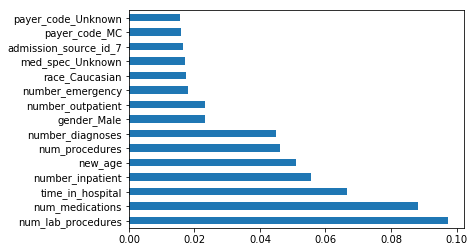

In [13]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

#15 best features 
feat_importances = pd.Series(clf.feature_importances_, index=allFeatures)
feat_importances.nlargest(15).plot(kind='barh')

#For the validation set
y_train_preds = clf.predict_proba(X_train_tf)[:,1]
y_valid_preds = clf.predict_proba(X_valid_tf)[:,1]

print('Random forest classifier')
print('Training set:')
results(y_train,y_train_preds, thresh)
print('Validation:')
results(y_valid,y_valid_preds, thresh)



In [14]:
# k-nearest neighbors
knn=KNeighborsClassifier(n_neighbors = 320)
knn.fit(X_train_tf, y_train)

#For the validation set
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training set:')
results(y_train,y_train_preds, thresh)
print('Validation:')
results(y_valid,y_valid_preds, thresh)



KNN
Training set:
AUC:0.644
accuracy:0.595
recall:0.476
precision:0.625
F1 score:0.540
 
Validation:
AUC:0.632
accuracy:0.595
recall:0.465
precision:0.172
F1 score:0.251
 


In [15]:
# logistic regression
lr=LogisticRegression(random_state = 100)
lr.fit(X_train_tf, y_train)

y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training set:')
results(y_train,y_train_preds, thresh)
print('Validation:')
results(y_valid,y_valid_preds, thresh)



Logistic Regression
Training set:
AUC:0.678
accuracy:0.629
recall:0.574
precision:0.645
F1 score:0.607
 
Validation:
AUC:0.657
accuracy:0.629
recall:0.560
precision:0.180
F1 score:0.272
 


In [16]:
# Decision tree
tree = DecisionTreeClassifier(max_depth = 15, random_state = 100)
tree.fit(X_train_tf, y_train)

y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training set:')
results(y_train,y_train_preds, thresh)
print('Validation:')
results(y_valid,y_valid_preds, thresh)




Logistic Regression
Training set:
AUC:0.847
accuracy:0.752
recall:0.699
precision:0.782
F1 score:0.738
 
Validation:
AUC:0.596
accuracy:0.752
recall:0.523
precision:0.159
F1 score:0.244
 
